In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt, IPython.display as ipd, numpy as np
import librosa, librosa.display

/home/violet/projects/wpi/research/MPRL/HRI/librosaTests/venv/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/violet/projects/wpi/research/MPRL/HRI/librosaTests/venv/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [3]:
y, sr = librosa.load('./audio_samples/480bpm.wav')
ipd.Audio(y, rate=sr)

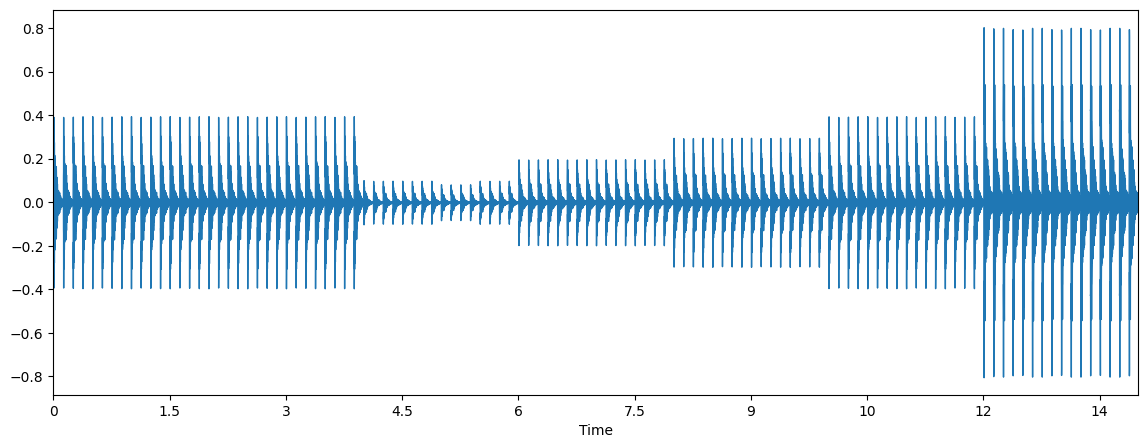

In [4]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

[0.06965986 0.16253968]


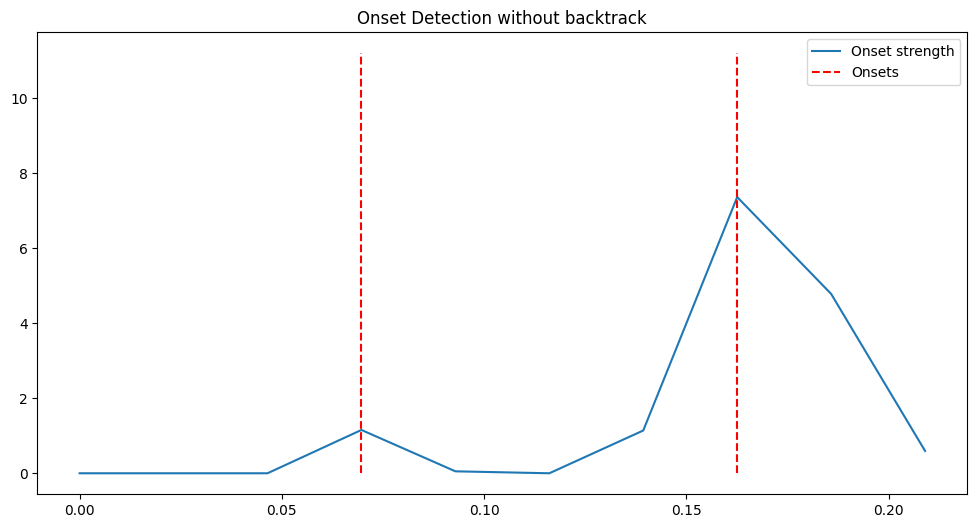

2


In [5]:
import math

onset_envelope = librosa.onset.onset_strength(y, sr=sr)

# Detect onsets using peak picking
onset_frames = librosa.util.peak_pick(onset_envelope, 3, 3, 3, 3, 0.5, 2)[0:2]

# Convert frame indices to time
onset_times = librosa.frames_to_time(onset_frames, sr=sr)

# Print onset times
print(onset_times)

# Visualize the results
times = librosa.times_like(onset_envelope, sr=sr)
plt.figure(figsize=(12, 6))
ax = plt.subplot()
ax.plot(times[0:10], onset_envelope[0:10], label='Onset strength')
ax.vlines(onset_times, 0, onset_envelope.max(), color='r', linestyle='--', label='Onsets')
ax.legend()
ax.set(title='Onset Detection without backtrack')
plt.show()

print(len(onset_times))

[0.11609977]


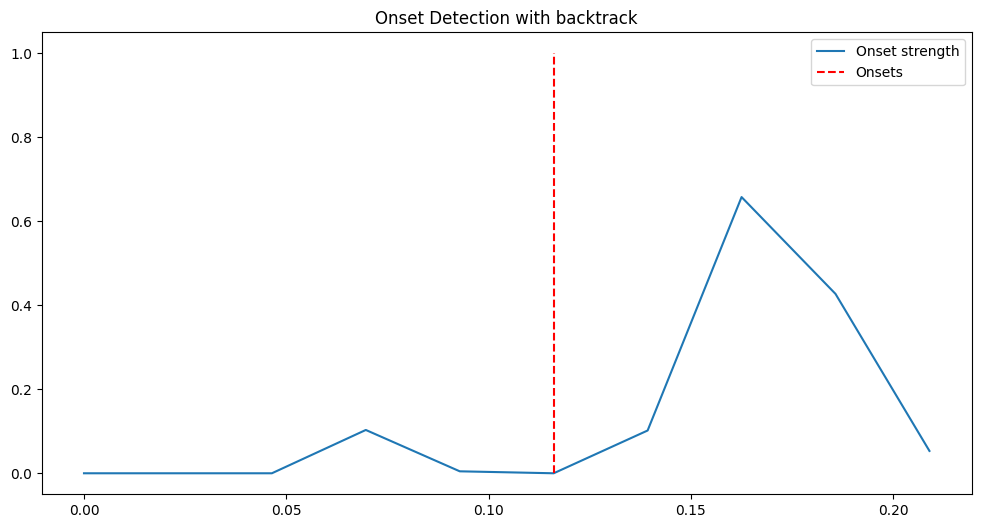

1


In [6]:
import math

onset_envelope = librosa.onset.onset_strength(y, sr=sr)

# Detect onsets using peak picking
onset_frames = librosa.onset.onset_detect(y=y, sr=sr, onset_envelope=onset_envelope, backtrack=True)


# Convert frame indices to time
onset_times = librosa.frames_to_time(onset_frames, sr=sr)[0:1]

# Print onset times
print(onset_times)

# Visualize the results
times = librosa.times_like(onset_envelope, sr=sr)
plt.figure(figsize=(12, 6))
ax = plt.subplot()
ax.plot(times[0:10], onset_envelope[0:10], label='Onset strength')
ax.vlines(onset_times, 0, onset_envelope.max(), color='r', linestyle='--', label='Onsets')
ax.legend()
ax.set(title='Onset Detection with backtrack')
plt.show()

print(len(onset_times))

In [64]:
import math
import numpy as np
def array_contains_ish(array, val, deviation_thresh=0.05):
    """
    Should return if array contains a value +-deviation_thresh away from the target.
    
    Asserts that there's a single match, since for our case we want for there to be 
    two points for a single value.
    """
    match_indexes = []
    lower_bound = val - deviation_thresh
    upper_bound = val + deviation_thresh
    for index, i in enumerate(array):
        if i > lower_bound and i < upper_bound:
            match_indexes.append(index)
    return match_indexes

def score_onset_detection(detected_onsets: np.ndarray, truth_onsets: np.ndarray, threshold=0.03):
    """
    Should take two onset arrays (one containing detected onsets and the other containing what it should have)
    and output the following:
    
    accuracy: % of detections that fall between +- some amount of the actual truth value 
    recall:  % of the actual onsets we correctly detected 
    avg_latency: the average latency of the group
    precision: std of the latencies 
    
    """
    detected_onsets_copy = np.copy(detected_onsets) # copied so we are editing only the local version
    truth_onsets_copy = np.copy(truth_onsets)
    
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    for detected_onset in detected_onsets:
        corresponding_actual_onsets = array_contains_ish(truth_onsets, detected_onset, threshold)
        if (len(corresponding_actual_onsets) == 0):
            false_positives += 1
            detected_onsets_copy = np.delete(detected_onsets_copy, np.where(detected_onsets_copy==detected_onset)[0][0])
    
    for true_onset in truth_onsets:
        detected_matches = array_contains_ish(detected_onsets_copy, true_onset, threshold)
        if (len(detected_matches) > 1):
            # print(f'{len(detected_matches)} hits detected for onset at {true_onset}')
            for index, element in enumerate(detected_matches):
                if index == 0:
                    true_positives += 1
                    continue # keep first match
                detected_onsets_copy = np.delete(detected_onsets_copy, element)
                false_positives += 1
        elif (len(detected_matches) == 1):
            true_positives += 1 
        else:
            false_negatives += 1
            truth_onsets_copy = np.delete(truth_onsets_copy, np.where(truth_onsets_copy==true_onset)[0][0])

    
            
    
            
    assert len(truth_onsets_copy) == len(detected_onsets_copy), f"some duplicates were not caught :(. # actual onsets: {len(truth_onsets_copy)}, # detected {len(detected_onsets_copy)}"
    
    latencies = np.subtract(truth_onsets_copy, detected_onsets_copy)
    
    accuracy = true_positives / len(detected_onsets)
    recall = true_positives / len(truth_onsets)
    avg_latency = np.average(latencies)
    precision = np.std(latencies)
    
    return accuracy, recall, avg_latency, precision

def score_librosa_onsets(detected_onset_times: np.ndarray, bpm, threshold=0.05):
    
    actual_onset_times = np.arange(0, 14, 60/bpm)
    
    print(score_onset_detection(detected_onset_times, actual_onset_times, threshold))

In [67]:
print('---------------------------manual----------------------')
for i in [120, 240, 480]:
    y, sr = librosa.load(f'./audio_samples/{i}bpm.wav')
    onset_envelope = librosa.onset.onset_strength(y, sr=sr)

    # Detect onsets using peak picking
    onset_frames = librosa.util.peak_pick(onset_envelope, 3, 3, 3, 3, 0.5, 2)

    # Convert frame indices to time
    onset_times = librosa.frames_to_time(onset_frames, sr=sr)
    score_librosa_onsets(onset_times, i)
    
print('---------------------------w/ backtrack----------------------')

for i in [120, 240, 480]:
    y, sr = librosa.load(f'./audio_samples/{i}bpm.wav')
    # onset_envelope = librosa.onset.onset_strength(y, sr=sr)

    # Detect onsets using peak picking
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr, backtrack=True)

    # Convert frame indices to time
    onset_times = librosa.frames_to_time(onset_frames, sr=sr)
    
    
    score_librosa_onsets(onset_times, i)

---------------------------manual----------------------
(0.9642857142857143, 0.9642857142857143, -0.025326278659612025, 0.006993221170617757)
(0.9821428571428571, 0.9821428571428571, -0.02635827664399096, 0.007000026878012209)
(0.8392857142857143, 0.8392857142857143, -0.040069715829594225, 0.005775650384879328)
---------------------------w/ backtrack----------------------
(1.0, 0.9642857142857143, 0.009073654153019294, 0.006581839130766675)
(0.9818181818181818, 0.9642857142857143, 0.009862685815066786, 0.008004354825153622)
(1.0, 0.9910714285714286, 0.007865007865007868, 0.006815828518395826)


In [68]:
import pandas as pd 

df = pd.read_csv('../onset_experiment.csv')

capacitive_onsets = (df[df["capacitive_detection"] == 1]["time (ms)"] * 0.001).values # 0.001 converts to seconds, so it can be compared with librosa

detected_onsets = (df[df["onset_detection"] == 1]["time (ms)"] * 0.001).values 

print(len(capacitive_onsets))
print(len(detected_onsets))

print(score_onset_detection(detected_onsets, capacitive_onsets, 0.05))
    
    


112
108


AssertionError: some duplicates were not caught :(. # actual onsets: 110, # detected 31